<a href="https://colab.research.google.com/github/sugyan/stable-diffusion-morphing/blob/main/stable_diffusion_morphing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stable Diffusion morphing

Generate morphing animations from images generated by Stable Diffusion.

[Stable Diffusion](https://github.com/CompVis/stable-diffusion) by Robin Rombach, Andreas Blattmann, Dominik Lorenz, Patrick Esser, Björn Ommer and the [Stability.ai](https://stability.ai/) Team.

This notebook is hosted on [github.com/sugyan](https://github.com/sugyan/stable-diffusion-morphing)

## Setup


In [1]:
#@title NVIDIA GPU
!nvidia-smi

Mon Nov 21 02:35:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#@title Install `huggingface_hub`, enable custom widget manager
!pip install huggingface_hub

from google.colab import output
output.enable_custom_widget_manager()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 182 kB 4.1 MB/s 


In [3]:
#@title Authenticate huggingface token
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [4]:
#@title Load model
!pip install diffusers[torch]==0.7.2 transformers accelerate scipy ftfy pytorch_lightning

import torch
from diffusers import StableDiffusionPipeline


def get_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device("cuda")
    if torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")


device = get_device()
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", revision="fp16", torch_dtype=torch.float16
)
pipe = pipe.to(device)
# pipe.enable_sequential_cpu_offload()
# pipe.enable_attention_slicing(1)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 304 kB 4.1 MB/s 
     |████████████████████████████████| 5.5 MB 26.3 MB/s 
     |████████████████████████████████| 175 kB 79.4 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 798 kB 66.9 MB/s 
     |████████████████████████████████| 7.6 MB 74.0 MB/s 
     |████████████████████████████████| 529 kB 74.1 MB/s 
     |████████████████████████████████| 87 kB 8.2 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115940 sha256=d56e6312abe65f1d172184f40fc4866916fc9d244912e65a791a7d0ce4d9a485
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.70k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/284 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/636 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/822 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/609 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

## Prepare to generate images

In [5]:
#@title Define `generate` function
import inspect
import logging
from typing import Callable, List, Optional

from PIL.Image import Image


@torch.no_grad()
def prompt2embeddings(
    pipe: StableDiffusionPipeline,
    prompt: str,
    guidance_scale: float = 7.5,
    negative_prompt: Optional[str] = None,
) -> torch.Tensor:
    batch_size = 1

    # get prompt text embeddings
    text_inputs = pipe.tokenizer(
        prompt,
        padding="max_length",
        max_length=pipe.tokenizer.model_max_length,
        return_tensors="pt",
    )
    text_input_ids = text_inputs.input_ids

    if text_input_ids.shape[-1] > pipe.tokenizer.model_max_length:
        removed_text = pipe.tokenizer.batch_decode(
            text_input_ids[:, pipe.tokenizer.model_max_length :]
        )
        logger.warning(
            "The following part of your input was truncated because CLIP can only handle sequences up to"
            f" {pipe.tokenizer.model_max_length} tokens: {removed_text}"
        )
        text_input_ids = text_input_ids[:, : pipe.tokenizer.model_max_length]
    text_embeddings = pipe.text_encoder(text_input_ids.to(pipe.device))[0]

    # duplicate text embeddings for each generation per prompt, using mps friendly method
    bs_embed, seq_len, _ = text_embeddings.shape
    text_embeddings = text_embeddings.repeat(1, 1, 1)
    text_embeddings = text_embeddings.view(bs_embed, seq_len, -1)

    # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
    # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
    # corresponds to doing no classifier free guidance.
    do_classifier_free_guidance = guidance_scale > 1.0
    # get unconditional embeddings for classifier free guidance
    if do_classifier_free_guidance:
        uncond_tokens: List[str]
        if negative_prompt is None:
            uncond_tokens = [""]
        elif type(prompt) is not type(negative_prompt):
            raise TypeError(
                f"`negative_prompt` should be the same type to `prompt`, but got {type(negative_prompt)} !="
                f" {type(prompt)}."
            )
        elif isinstance(negative_prompt, str):
            uncond_tokens = [negative_prompt]
        elif batch_size != len(negative_prompt):
            raise ValueError(
                f"`negative_prompt`: {negative_prompt} has batch size {len(negative_prompt)}, but `prompt`:"
                f" {prompt} has batch size {batch_size}. Please make sure that passed `negative_prompt` matches"
                " the batch size of `prompt`."
            )
        else:
            uncond_tokens = negative_prompt

        max_length = text_input_ids.shape[-1]
        uncond_input = pipe.tokenizer(
            uncond_tokens,
            padding="max_length",
            max_length=max_length,
            truncation=True,
            return_tensors="pt",
        )
        uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(pipe.device))[0]

        # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
        seq_len = uncond_embeddings.shape[1]
        uncond_embeddings = uncond_embeddings.repeat(batch_size, 1, 1)
        uncond_embeddings = uncond_embeddings.view(batch_size, seq_len, -1)

        # For classifier free guidance, we need to do two forward passes.
        # Here we concatenate the unconditional and text embeddings into a single batch
        # to avoid doing two forward passes
        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    return text_embeddings


@torch.no_grad()
def generate(
    pipe: StableDiffusionPipeline,
    text_embeddings: torch.Tensor,
    latents: torch.Tensor,
    height: int = 512,
    width: int = 512,
    num_inference_steps: int = 50,
    guidance_scale: float = 7.5,
    eta: float = 0.0,
    callback: Optional[Callable[[int, int, torch.Tensor], None]] = None,
    callback_steps: Optional[int] = 1,
) -> Image:
    batch_size = 1

    if height % 8 != 0 or width % 8 != 0:
        raise ValueError(
            f"`height` and `width` have to be divisible by 8 but are {height} and {width}."
        )

    if (callback_steps is None) or (
        callback_steps is not None
        and (not isinstance(callback_steps, int) or callback_steps <= 0)
    ):
        raise ValueError(
            f"`callback_steps` has to be a positive integer but is {callback_steps} of type"
            f" {type(callback_steps)}."
        )

    latents_shape = (
        batch_size,
        pipe.unet.in_channels,
        height // 8,
        width // 8,
    )
    if latents.shape != latents_shape:
        raise ValueError(
            f"Unexpected latents shape, got {latents.shape}, expected {latents_shape}"
        )

    # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
    # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
    # corresponds to doing no classifier free guidance.
    do_classifier_free_guidance = guidance_scale > 1.0

    # set timesteps
    pipe.scheduler.set_timesteps(num_inference_steps)

    # Some schedulers like PNDM have timesteps as arrays
    # It's more optimized to move all timesteps to correct device beforehand
    timesteps_tensor = pipe.scheduler.timesteps.to(pipe.device)

    # scale the initial noise by the standard deviation required by the scheduler
    latents = latents * pipe.scheduler.init_noise_sigma

    # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
    # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
    # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
    # and should be between [0, 1]
    accepts_eta = "eta" in set(inspect.signature(pipe.scheduler.step).parameters.keys())
    extra_step_kwargs = {}
    if accepts_eta:
        extra_step_kwargs["eta"] = eta

    for i, t in enumerate(pipe.progress_bar(timesteps_tensor)):
        # expand the latents if we are doing classifier free guidance
        latent_model_input = (
            torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        )
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        noise_pred = pipe.unet(
            latent_model_input, t, encoder_hidden_states=text_embeddings
        ).sample

        # perform guidance
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (
                noise_pred_text - noise_pred_uncond
            )

        # compute the previous noisy sample x_t -> x_t-1
        latents = pipe.scheduler.step(
            noise_pred, t, latents, **extra_step_kwargs
        ).prev_sample

        # call the callback, if provided
        if callback is not None and i % callback_steps == 0:
            callback(i, t, latents)

    latents = 1 / 0.18215 * latents
    image = pipe.vae.decode(latents).sample

    image = (image / 2 + 0.5).clamp(0, 1)

    # we always cast to float32 as this does not cause significant overhead and is compatible with bfloa16
    return pipe.numpy_to_pil(image.cpu().permute(0, 2, 3, 1).float().numpy())[0]

INFO:lightning_lite.utilities.seed:Global seed set to 42


  0%|          | 0/51 [00:00<?, ?it/s]

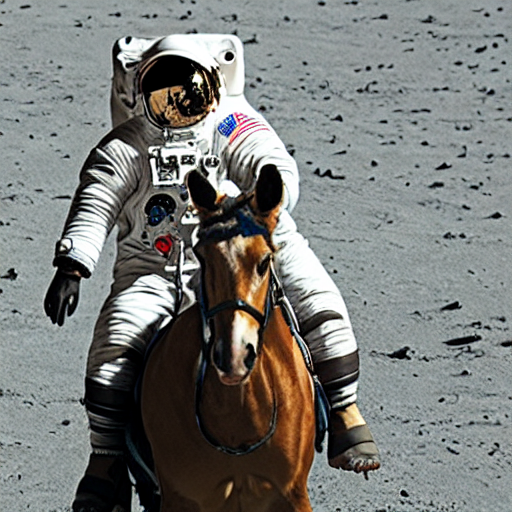

In [6]:
#@title Check if `generate` works
from pytorch_lightning import seed_everything


prompt = "a photograph of an astronaut riding a horse"  #@param {type:"string"}
seed = 42  #@param {type: "integer"}

seed_everything(seed)
latents = torch.randn([1, 4, 64, 64], device="cpu").to(device)
text_embeddings = prompt2embeddings(pipe, prompt)
precision_scope = torch.autocast("cuda" if get_device().type == "cuda" else "cpu")
with precision_scope:
    image = generate(pipe, text_embeddings=text_embeddings, latents=latents)
image

## Generate frames

Define `inputs` for morphing (list of `seed` and `prompt`)

In [7]:
from dataclasses import dataclass
from typing import List


@dataclass
class Input:
    seed: int
    prompt: str


inputs: List[Input] = [
    Input(seed=42, prompt="photo of an apple"),
    Input(seed=42, prompt="photo of a pineapple"),
    Input(seed=4200, prompt="photo of a pineapple"),
]

### Run

if `loop` is `True`, `interpolation_steps * len(inputs)` images will be generated.

In [8]:
import shutil
from math import sinh
from pathlib import Path
from typing import List

import numpy as np
from pytorch_lightning import seed_everything


def slerp(
    t: float, v0: torch.Tensor, v1: torch.Tensor, DOT_THRESHOLD: float = 0.9995
) -> torch.Tensor:
    u0 = v0 / v0.norm()
    u1 = v1 / v1.norm()
    dot = (u0 * u1).sum()
    if dot.abs() > DOT_THRESHOLD:
        return (1 - t) * v0 + t * v1
    omega = dot.acos()
    return (((1.0 - t) * omega).sin() * v0 + (t * omega).sin() * v1) / omega.sin()


def morphing(
    inputs: List[Input], steps: int, num_inference_steps: int, loop: bool
) -> None:
    outdir = Path("/content/outputs/morphing")
    shutil.rmtree(outdir, ignore_errors=True)
    outdir.mkdir(parents=True)

    latents_list = []
    for input in inputs:
        seed_everything(input.seed)
        latents_list.append(torch.randn([1, 4, 64, 64], device="cpu").to(device))

    precision_scope = torch.autocast("cuda" if get_device().type == "cuda" else "cpu")
    a = np.arccosh(5.0)
    idx = 0
    for i in range(len(inputs)):
        i0, i1 = i, (i + 1) % len(inputs)
        l0 = latents_list[i0]
        l1 = latents_list[i1]
        e0 = prompt2embeddings(pipe, inputs[i0].prompt)
        e1 = prompt2embeddings(pipe, inputs[i1].prompt)
        for j in range(steps):
            print(f"genearate image {idx}: {i}/{len(inputs)}, {j}/{steps}")
            t = j / steps
            xc = sinh(a * (t * 2.0 - 1.0)) / sinh(a) / 2.0 + 0.5

            text_embeddings = e0 * (1.0 - xc) + e1 * xc
            latents = slerp(t, l0, l1)
            with precision_scope:
                img = generate(
                    pipe,
                    text_embeddings=text_embeddings,
                    latents=latents,
                    num_inference_steps=num_inference_steps,
                )
            img.save(outdir / f"{idx:04d}.png")
            idx += 1
            if not loop and i == len(inputs) - 1:
                break


interpolation_steps = 24 #@param {type:"integer"}
num_inference_steps = 50 #@param {type:"integer"}
loop = True #@param {type:"boolean"}

morphing(inputs, interpolation_steps, num_inference_steps, loop)

INFO:lightning_lite.utilities.seed:Global seed set to 42
INFO:lightning_lite.utilities.seed:Global seed set to 42
INFO:lightning_lite.utilities.seed:Global seed set to 4200


genearate image 0: 0/3, 0/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 1: 0/3, 1/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 2: 0/3, 2/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 3: 0/3, 3/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 4: 0/3, 4/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 5: 0/3, 5/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 6: 0/3, 6/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 7: 0/3, 7/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 8: 0/3, 8/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 9: 0/3, 9/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 10: 0/3, 10/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 11: 0/3, 11/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 12: 0/3, 12/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 13: 0/3, 13/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 14: 0/3, 14/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 15: 0/3, 15/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 16: 0/3, 16/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 17: 0/3, 17/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 18: 0/3, 18/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 19: 0/3, 19/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 20: 0/3, 20/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 21: 0/3, 21/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 22: 0/3, 22/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 23: 0/3, 23/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 24: 1/3, 0/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 25: 1/3, 1/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 26: 1/3, 2/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 27: 1/3, 3/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 28: 1/3, 4/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 29: 1/3, 5/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 30: 1/3, 6/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 31: 1/3, 7/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 32: 1/3, 8/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 33: 1/3, 9/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 34: 1/3, 10/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 35: 1/3, 11/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 36: 1/3, 12/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 37: 1/3, 13/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 38: 1/3, 14/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 39: 1/3, 15/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 40: 1/3, 16/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 41: 1/3, 17/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 42: 1/3, 18/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 43: 1/3, 19/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 44: 1/3, 20/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 45: 1/3, 21/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 46: 1/3, 22/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 47: 1/3, 23/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 48: 2/3, 0/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 49: 2/3, 1/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 50: 2/3, 2/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 51: 2/3, 3/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 52: 2/3, 4/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 53: 2/3, 5/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 54: 2/3, 6/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 55: 2/3, 7/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 56: 2/3, 8/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 57: 2/3, 9/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 58: 2/3, 10/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 59: 2/3, 11/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 60: 2/3, 12/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 61: 2/3, 13/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 62: 2/3, 14/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 63: 2/3, 15/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 64: 2/3, 16/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 65: 2/3, 17/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 66: 2/3, 18/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 67: 2/3, 19/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 68: 2/3, 20/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 69: 2/3, 21/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 70: 2/3, 22/24


  0%|          | 0/51 [00:00<?, ?it/s]

genearate image 71: 2/3, 23/24


  0%|          | 0/51 [00:00<?, ?it/s]

## Create video from frames 

In [9]:
#@title Create video by `ffmpeg` and display
import subprocess
from base64 import b64encode
from IPython import display

output_path = "/content/out.mp4" #@param {type:"string"}
fps = 12 #@param {type:"integer"}
cmd = [
    'ffmpeg',
    '-y',
    '-vcodec', 'png',
    '-r', str(fps),
    '-start_number', str(0),
    '-i', "/content/outputs/morphing/%04d.png",
    '-c:v', 'libx264',
    '-vf',
    f'fps={fps}',
    '-pix_fmt', 'yuv420p',
    '-crf', '17',
    '-preset', 'veryfast',
    output_path,
]
process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = process.communicate()
if process.returncode != 0:
    print(stderr)
    raise RuntimeError(stderr)

mp4 = open(output_path, "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
display.display(display.HTML(f'<video controls loop><source src="{data_url}" type="video/mp4"></video>'))

In [10]:
#@title Download video
from google.colab import files
files.download(output_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>